In [1]:
# In a new cell, run this first to install the necessary library
!pip install pandas-datareader

In [2]:
# Import necessary libraries
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set the start and end dates for our data
start = datetime(2000, 2, 1)
end = datetime.now()

# Define the FRED series IDs
credit_spread_id = 'BAMLC0A0CM'
vix_id = 'VIXCLS'
recession_id = 'USREC' # US Recession indicator

# Download the data from FRED
credit_spread = web.DataReader(credit_spread_id, 'fred', start, end)
vix = web.DataReader(vix_id, 'fred', start, end)
recession = web.DataReader(recession_id, 'fred', start, end)


# --- Data Cleaning and Merging ---

# Rename columns for clarity
credit_spread.columns = ['CreditSpread']
vix.columns = ['VIX']

# Merge the two series into a single DataFrame
df = credit_spread.join(vix, how='inner')

# Handle missing values - FRED data has NaNs for holidays. Forward-fill is a good strategy.
df.fillna(method='ffill', inplace=True)

# Merge the recession data
df = df.join(recession, how='left')
df['USREC'].fillna(method='ffill', inplace=True) # Forward fill recession data as well

# Display the first few rows and summary info
print("First 5 rows of the dataset:")
print(df.head())
print("\nLast 5 rows of the dataset:")
print(df.tail())
print("\nDataset Information:")
df.info()

First 5 rows of the dataset:
            CreditSpread    VIX  USREC
DATE                                  
2000-02-01          1.21  23.45    0.0
2000-02-02          1.19  23.12    0.0
2000-02-03          1.20  22.01    0.0
2000-02-04          1.17  21.54    0.0
2000-02-07          1.18  22.79    0.0

Last 5 rows of the dataset:
            CreditSpread    VIX  USREC
DATE                                  
2025-08-26          0.78  14.62    0.0
2025-08-27          0.78  14.85    0.0
2025-08-28          0.79  14.43    0.0
2025-08-29          0.79  15.36    0.0
2025-09-01          0.81  16.12    0.0

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6675 entries, 2000-02-01 to 2025-09-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CreditSpread  6675 non-null   float64
 1   VIX           6675 non-null   float64
 2   USREC         6675 non-null   float64
dtypes: float64(3)
memory usage: 20

/tmp/ipython-input-2773809218.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-2773809218.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['USREC'].fillna(method='ffill', inplace=True) # Forward fill recession data as well
/tmp/ipython-input-2773809218.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() o

In [3]:
df.to_csv('data.csv')

In [4]:
df['USREC'].value_counts()

,count
USREC,
0.0,6087
1.0,588


/tmp/ipython-input-2330234689.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['USREC'][i] == 1 and df['USREC'][i-1] == 0:
/tmp/ipython-input-2330234689.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['USREC'][i] == 0 and df['USREC'][i-1] == 1:


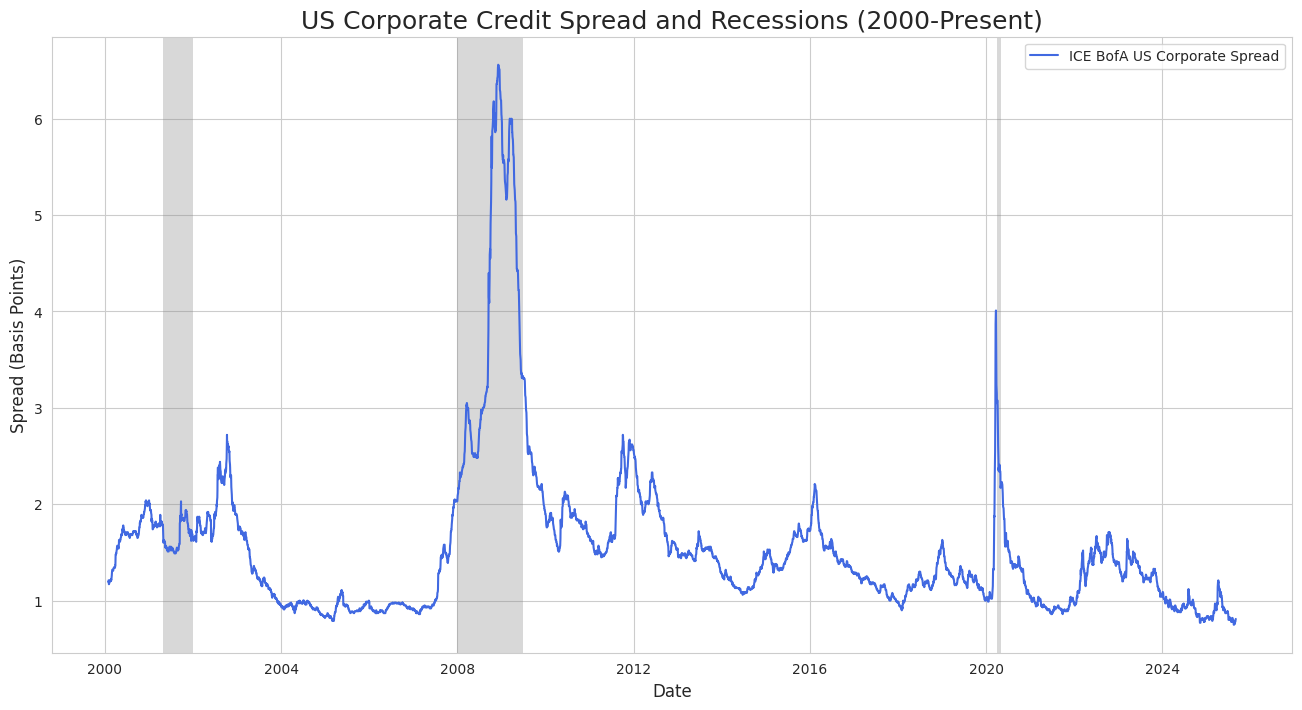

In [5]:
# Set plot style
sns.set_style('whitegrid')

# Create the plot
plt.figure(figsize=(16, 8))

# Plot the Credit Spread
plt.plot(df.index, df['CreditSpread'], label='ICE BofA US Corporate Spread', color='royalblue')

# Shade the recession periods
for i in range(len(df)):
    if df['USREC'][i] == 1 and df['USREC'][i-1] == 0:
        start_date = df.index[i]
    if df['USREC'][i] == 0 and df['USREC'][i-1] == 1:
        end_date = df.index[i]
        plt.axvspan(start_date, end_date, color='gray', alpha=0.3, lw=0)

plt.title('US Corporate Credit Spread and Recessions (2000-Present)', fontsize=18)
plt.ylabel('Spread (Basis Points)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.show()

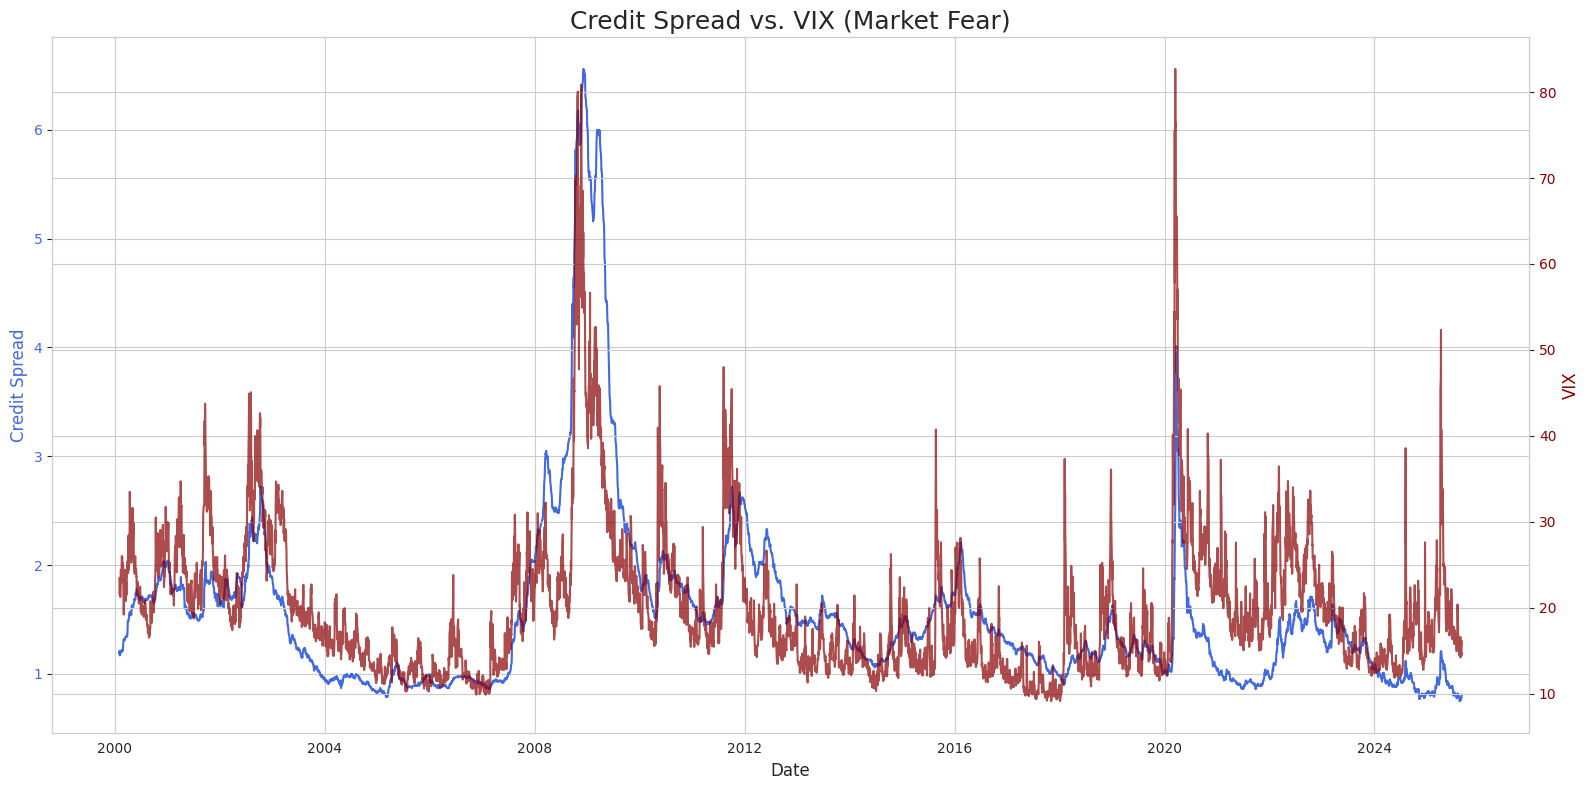

--- ADF Test for Original Credit Spread ---
ADF Statistic: -3.1307
p-value: 0.0244
Conclusion: Strong evidence against the null hypothesis. The series is stationary.
--- ADF Test for Original VIX ---
ADF Statistic: -5.9998
p-value: 0.0000
Conclusion: Strong evidence against the null hypothesis. The series is stationary.

--- After First Differencing ---
--- ADF Test for Differenced Credit Spread ---
ADF Statistic: -12.4477
p-value: 0.0000
Conclusion: Strong evidence against the null hypothesis. The series is stationary.
--- ADF Test for Differenced VIX ---
ADF Statistic: -34.0803
p-value: 0.0000
Conclusion: Strong evidence against the null hypothesis. The series is stationary.


In [6]:
# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot the Credit Spread on the primary y-axis
color = 'royalblue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Credit Spread', color=color, fontsize=12)
ax1.plot(df.index, df['CreditSpread'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for the VIX
ax2 = ax1.twinx()
color = 'darkred'
ax2.set_ylabel('VIX', color=color, fontsize=12)
ax2.plot(df.index, df['VIX'], color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Credit Spread vs. VIX (Market Fear)', fontsize=18)
fig.tight_layout()
plt.show()

### **Step 3: Stationarity Check and Preprocessing**

from statsmodels.tsa.stattools import adfuller

# Create a function for the ADF test
def adf_test(series, name=''):
    result = adfuller(series.dropna())
    print(f'--- ADF Test for {name} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("Conclusion: Strong evidence against the null hypothesis. The series is stationary.")
    else:
        print("Conclusion: Weak evidence against null hypothesis. The series is non-stationary.")

# Test the original series
adf_test(df['CreditSpread'], 'Original Credit Spread')
adf_test(df['VIX'], 'Original VIX')

# --- Make the series stationary by differencing ---
# We will use the first difference to remove the trend
df['CreditSpread_diff'] = df['CreditSpread'].diff().dropna()
df['VIX_diff'] = df['VIX'].diff().dropna()

print("\n--- After First Differencing ---")
# Test the differenced series
adf_test(df['CreditSpread_diff'], 'Differenced Credit Spread')
adf_test(df['VIX_diff'], 'Differenced VIX')

In [7]:
# First, let's clean up our DataFrame to keep only the necessary differenced columns for modeling
# We drop the initial NaN values that result from differencing
df_model = df[['CreditSpread_diff', 'VIX_diff']].dropna()

# Split the data
n_obs = int(len(df_model) * 0.90)
train = df_model.iloc[:n_obs]
test = df_model.iloc[n_obs:]

print(f"Training set size: {len(train)}")
print(f"Testing set size: {len(test)}")
print(f"Training data from {train.index.min().date()} to {train.index.max().date()}")
print(f"Testing data from {test.index.min().date()} to {test.index.max().date()}")

Training set size: 6006
Testing set size: 668
Training data from 2000-02-02 to 2023-02-08
Testing data from 2023-02-09 to 2025-09-01


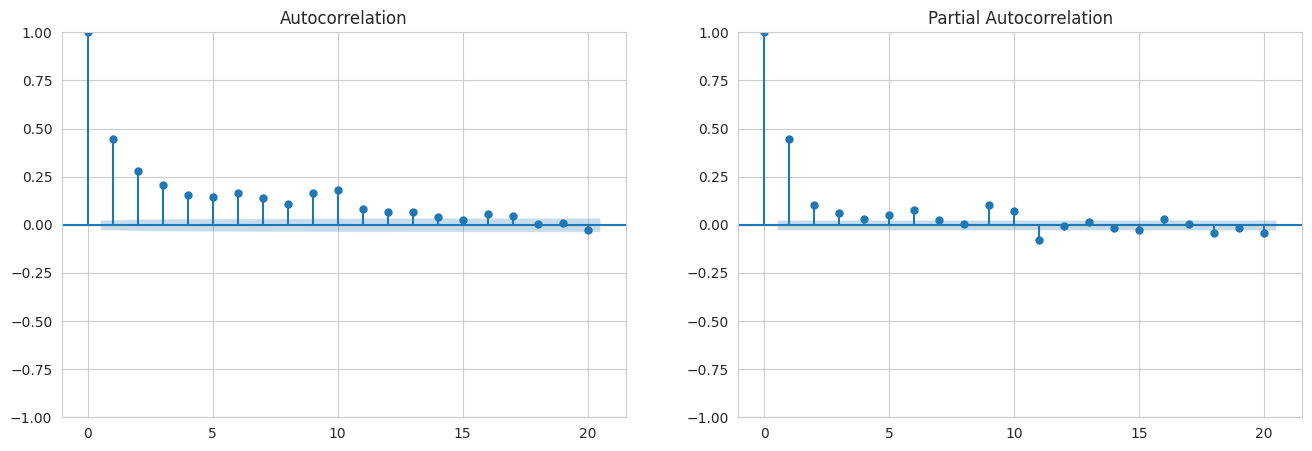

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF to determine p and q
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(train['CreditSpread_diff'], ax=axes[0], lags=20)
plot_pacf(train['CreditSpread_diff'], ax=axes[1], lags=20)
plt.show()

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Build and Train the ARIMA Model ---
# We are fitting on the differenced data, so we use ARIMA(p,0,q) or ARMA(p,q)
# Let's start with p=5, q=5 as suggested by the plots
arima_model = ARIMA(train['CreditSpread_diff'], order=(5, 0, 5))
arima_result = arima_model.fit()

print(arima_result.summary())

# --- Make Predictions on the Test Set ---
arima_pred_diff = arima_result.predict(start=test.index[0], end=test.index[-1])

# The predictions are differenced, we need to reverse the transformation
# First, get the last value of the original (non-differenced) training data
# We use n_obs here because it corresponds to the correct alignment with the differenced data
last_train_value = df['CreditSpread'].iloc[n_obs]

# Cumulatively sum the differenced predictions and add to the last known value
arima_pred = last_train_value + arima_pred_diff.cumsum()

# --- THE FIX IS HERE ---
# We now slice the original data from n_obs + 1 to get a matching length
actual_values_for_arima = df['CreditSpread'].iloc[n_obs+1:]

# Evaluate the model
arima_rmse = np.sqrt(mean_squared_error(actual_values_for_arima, arima_pred))
arima_mae = mean_absolute_error(actual_values_for_arima, arima_pred)

print(f"\nARIMA Model RMSE: {arima_rmse:.4f}")
print(f"ARIMA Model MAE: {arima_mae:.4f}")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:      CreditSpread_diff   No. Observations:                 6006
Model:                 ARIMA(5, 0, 5)   Log Likelihood               13988.657
Date:                Tue, 02 Sep 2025   AIC                         -27953.313
Time:                        15:52:17   BIC                         -27872.907
Sample:                    02-02-2000   HQIC                        -27925.392
                         - 02-08-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.326e-05      0.001     -0.022      0.982      -0.002       0.002
ar.L1          0.1286      0.094      1.374      0.169      -0.055       0.312
ar.L2          0.0661      0.106      0.626      0.5

In [10]:
# --- Build and Train the SARIMAX Model ---
exog_train = train[['VIX_diff']]
exog_test = test[['VIX_diff']]

sarimax_model = ARIMA(train['CreditSpread_diff'], exog=exog_train, order=(5, 0, 5))
sarimax_result = sarimax_model.fit()

print(sarimax_result.summary())

# --- Make Predictions on the Test Set ---
sarimax_pred_diff = sarimax_result.predict(start=test.index[0], end=test.index[-1], exog=exog_test)

# Reverse the differencing transformation
sarimax_pred = last_train_value + sarimax_pred_diff.cumsum()

# --- THE FIX IS HERE ---
# We use the same corrected slice for the actual values
actual_values_for_sarimax = df['CreditSpread'].iloc[n_obs+1:]

# Evaluate the model
sarimax_rmse = np.sqrt(mean_squared_error(actual_values_for_sarimax, sarimax_pred))
sarimax_mae = mean_absolute_error(actual_values_for_sarimax, sarimax_pred)

print(f"\nSARIMAX Model RMSE: {sarimax_rmse:.4f}")
print(f"SARIMAX Model MAE: {sarimax_mae:.4f}")

print("\n--- Comparison ---")
print(f"ARIMA (baseline) RMSE: {arima_rmse:.4f}")
print(f"SARIMAX (with VIX) RMSE: {sarimax_rmse:.4f}")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:      CreditSpread_diff   No. Observations:                 6006
Model:                 ARIMA(5, 0, 5)   Log Likelihood               14157.859
Date:                Tue, 02 Sep 2025   AIC                         -28289.717
Time:                        15:52:31   BIC                         -28202.611
Sample:                    02-02-2000   HQIC                        -28259.469
                         - 02-08-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.116      0.907      -0.002       0.002
VIX_diff       0.0025   6.21e-05     39.791      0.000       0.002       0.003
ar.L1          0.7170      0.135      5.330      0.0

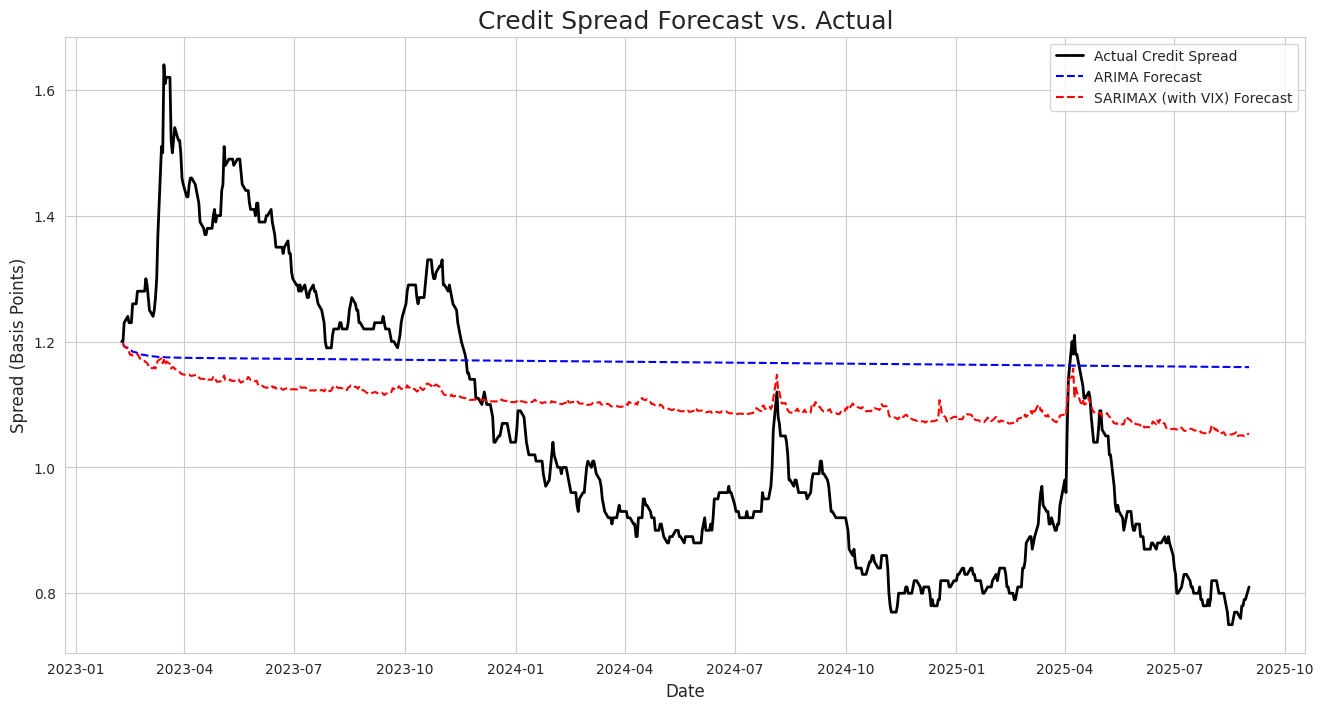

In [11]:
# Get the actual test data (non-differenced)
actual_test_data = df['CreditSpread'].iloc[n_obs:]

plt.figure(figsize=(16, 8))
plt.plot(actual_test_data.index, actual_test_data, label='Actual Credit Spread', color='black', linewidth=2)
plt.plot(arima_pred.index, arima_pred, label='ARIMA Forecast', color='blue', linestyle='--')
plt.plot(sarimax_pred.index, sarimax_pred, label='SARIMAX (with VIX) Forecast', color='red', linestyle='--')

plt.title('Credit Spread Forecast vs. Actual', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Spread (Basis Points)', fontsize=12)
plt.legend()
plt.show()

In [12]:
# Install Prophet library
!pip install prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmphjtyt5x8/5v2e1yn0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjtyt5x8/eipftssl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48505', 'data', 'file=/tmp/tmphjtyt5x8/5v2e1yn0.json', 'init=/tmp/tmphjtyt5x8/eipftssl.json', 'output', 'file=/tmp/tmphjtyt5x8/prophet_model1u03_3q2/prophet_model-20250902155238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet Model RMSE: 0.3554
Prophet Model MAE: 0.3018


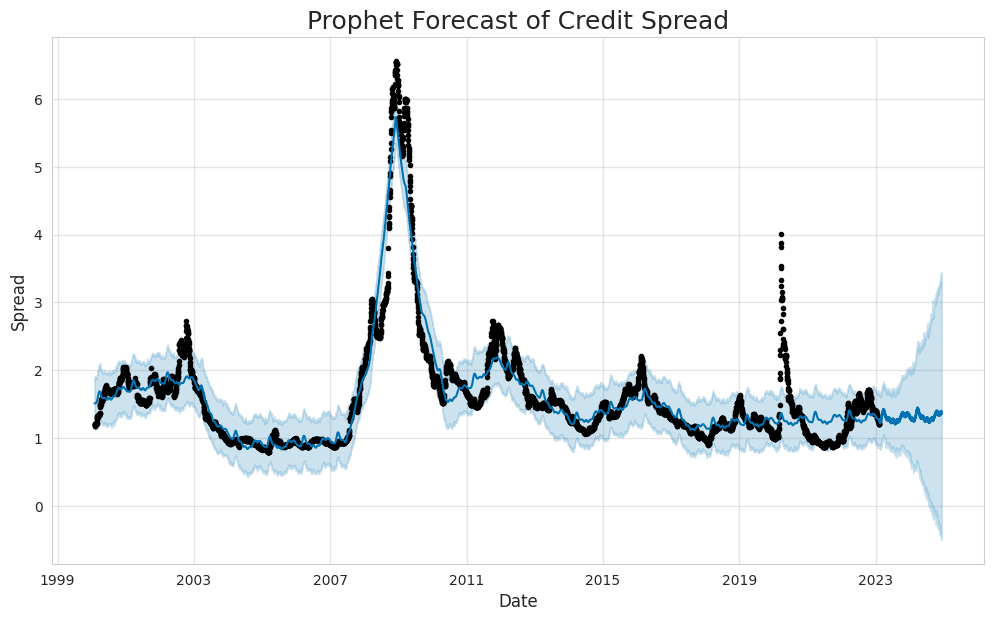

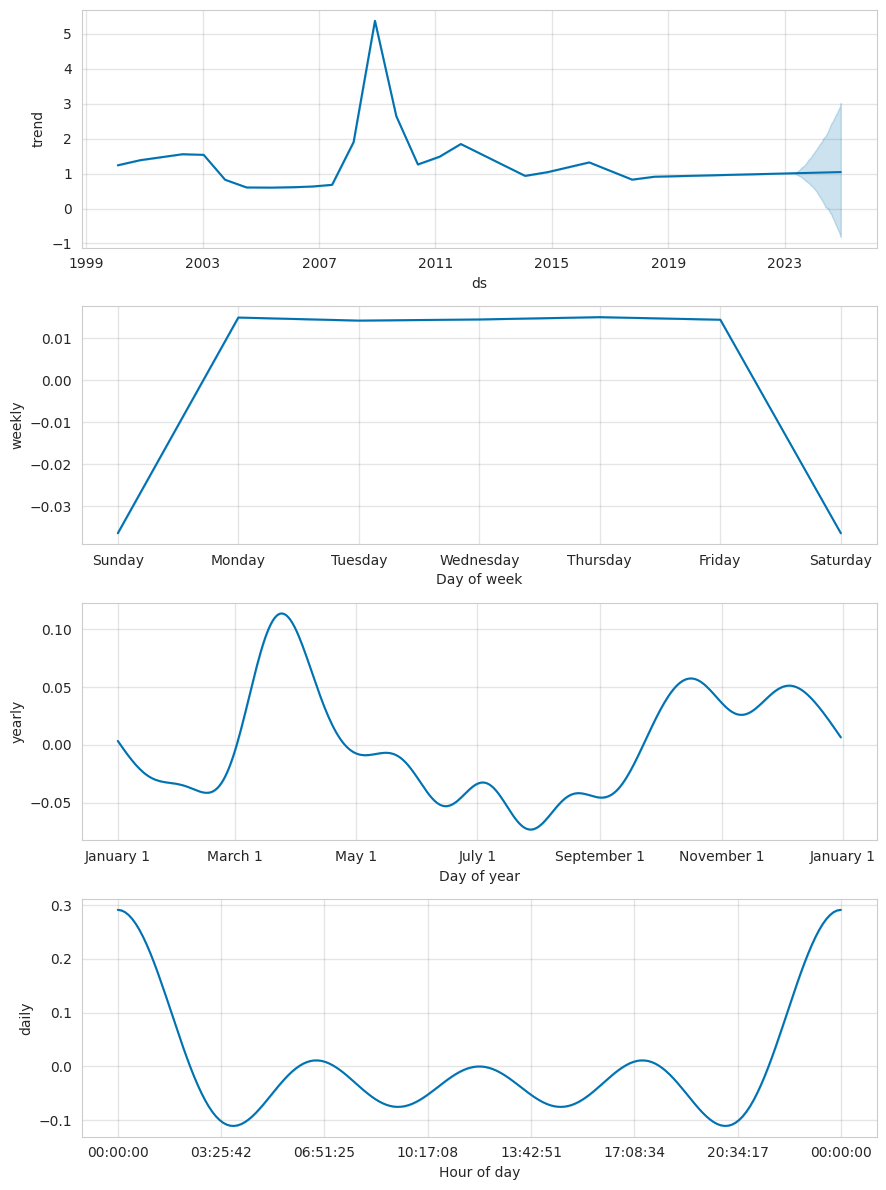

In [13]:
from prophet import Prophet

# --- Prepare Data for Prophet ---
# Prophet works on the original, non-differenced data.
# It requires columns named 'ds' and 'y'.
df_prophet = df[['CreditSpread']].reset_index()
df_prophet.columns = ['ds', 'y']

# Split the data into training and testing sets
train_prophet = df_prophet.iloc[:n_obs+1] # Use n_obs+1 to match the original df length
test_prophet = df_prophet.iloc[n_obs+1:]

# --- Build and Train the Prophet Model ---
# By default, Prophet will identify yearly and weekly seasonality.
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train_prophet)

# --- Make Future Predictions ---
# Create a future dataframe for the dates we want to predict
future = prophet_model.make_future_dataframe(periods=len(test_prophet))
prophet_forecast = prophet_model.predict(future)

# --- Evaluate the Model ---
# Extract the predictions for the test period
prophet_pred = prophet_forecast.iloc[-len(test_prophet):]['yhat']
actual_prophet = test_prophet['y']

prophet_rmse = np.sqrt(mean_squared_error(actual_prophet, prophet_pred))
prophet_mae = mean_absolute_error(actual_prophet, prophet_pred)

print(f"\nProphet Model RMSE: {prophet_rmse:.4f}")
print(f"Prophet Model MAE: {prophet_mae:.4f}")

# --- Plot the Prophet Forecast ---
fig = prophet_model.plot(prophet_forecast)
plt.title('Prophet Forecast of Credit Spread', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Spread', fontsize=12)
plt.show()

# Plot the components (trend, seasonality)
fig2 = prophet_model.plot_components(prophet_forecast)
plt.show()

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# --- 1. Select and Scale the Data ---
# We will use the original, non-differenced data for this.
# The LSTM will learn the trend by itself.
df_lstm = df[['CreditSpread', 'VIX']]

# Scale the data to be between 0 and 1. This is crucial for LSTM performance.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_lstm)

# --- 2. Create Training and Testing Datasets ---
# We will use the same 90/10 split point
train_size = n_obs + 1 # Aligning with our previous split
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# --- 3. Create Sequences ---
# We will look at the last 60 days of data (CreditSpread and VIX) to predict the 61st day's CreditSpread.
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        # The input sequence (X) will be the data for the past 'look_back' days
        X.append(data[i:(i + look_back), :]) # All features (CreditSpread, VIX)
        # The output (y) will be the CreditSpread on the next day
        y.append(data[i + look_back, 0]) # Only the first column (CreditSpread)
    return np.array(X), np.array(y)

look_back = 60
X_train, y_train = create_sequences(train_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (5947, 60, 2)
Shape of y_train: (5947,)
Shape of X_test: (608, 60, 2)
Shape of y_test: (608,)


In [15]:
# --- 4. Build the LSTM Model Architecture ---
lstm_model = Sequential()

# First LSTM layer
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))

# Second LSTM layer
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))

# Output layer - A single neuron to predict the scaled CreditSpread
lstm_model.add(Dense(units=1))

# Compile the model
# We use the 'adam' optimizer and 'mean_squared_error' as the loss function
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.summary()

# --- 5. Train the Model ---
# This is the step that uses the GPU.
# 'epochs' is the number of times the model sees the entire training dataset.
# 'batch_size' is the number of samples processed before the model is updated.
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.0050 - val_loss: 6.0082e-05
Epoch 2/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 9.6781e-04 - val_loss: 8.1032e-05
Epoch 3/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.9699e-04 - val_loss: 6.8465e-05
Epoch 4/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.6988e-04 - val_loss: 6.3229e-05
Epoch 5/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.2127e-04 - val_loss: 2.6462e-04
Epoch 6/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4.4467e-04 - val_loss: 6.2297e-05
Epoch 7/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.5855e-04 - val_loss: 1.3335e-04
Epoch 8/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.4828e-04 - val_loss: 6.5875e-05
Epoch 9/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.1211e-04 - val_loss: 4.7626e-05
Epoch 10/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.0027e-04 - val_loss: 7.1388e-05
Epoch 11/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss

In [16]:
# --- 6. Make Predictions ---
lstm_pred_scaled = lstm_model.predict(X_test)

# --- 7. Inverse Transform the Predictions ---
# We need to create a dummy array with the same shape as the original scaled data
# to inverse transform our single prediction column.
dummy_array = np.zeros((len(lstm_pred_scaled), scaled_data.shape[1]))
dummy_array[:, 0] = lstm_pred_scaled.ravel() # Put our predictions in the first column

# Now, inverse the scaling
lstm_pred = scaler.inverse_transform(dummy_array)[:, 0]

# Also inverse scale the actual test values for comparison
actual_lstm = df['CreditSpread'].iloc[train_size + look_back:]

# --- 8. Evaluate the Model ---
lstm_rmse = np.sqrt(mean_squared_error(actual_lstm, lstm_pred))
lstm_mae = mean_absolute_error(actual_lstm, lstm_pred)

print(f"\nLSTM Model RMSE: {lstm_rmse:.4f}")
print(f"LSTM Model MAE: {lstm_mae:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  

LSTM Model RMSE: 0.0321
LSTM Model MAE: 0.0235


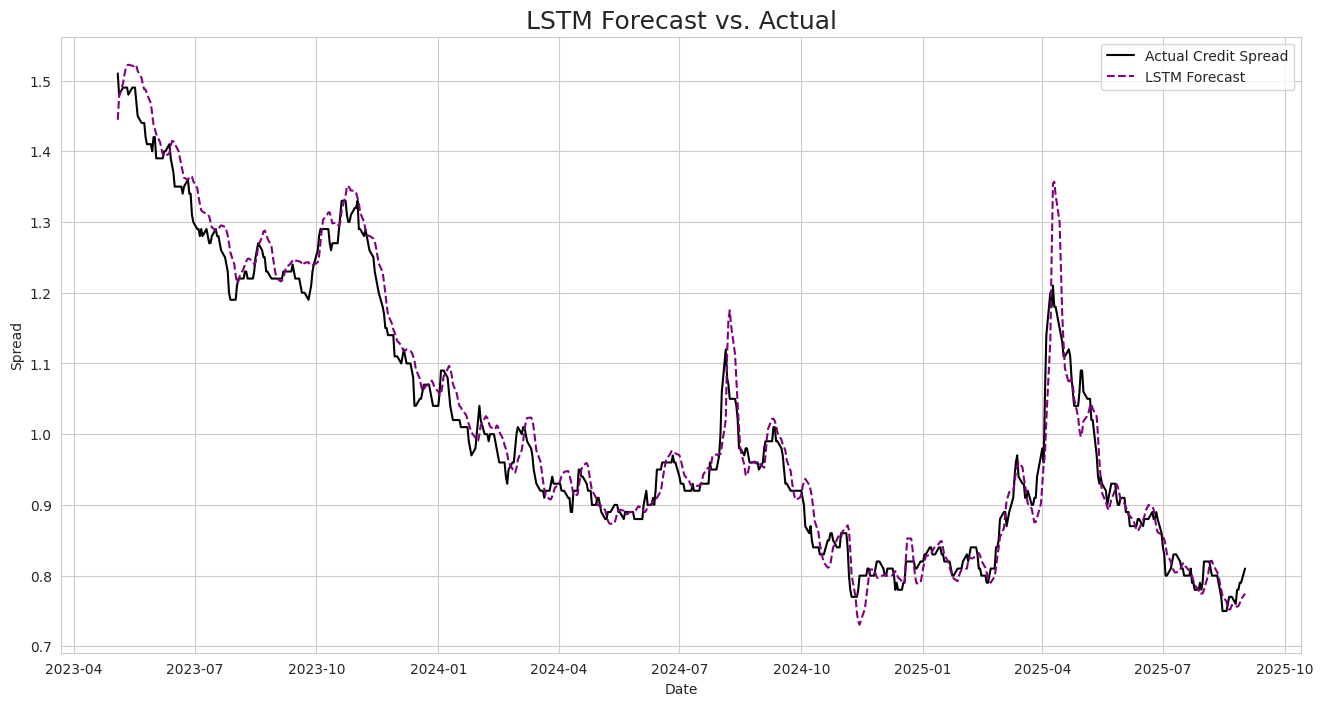

--- FINAL MODEL COMPARISON ---
ARIMA (Baseline) RMSE: 0.2417, MAE: 0.2168
SARIMAX (with VIX) RMSE: 0.1963, MAE: 0.1761
Prophet RMSE: 0.3554, MAE: 0.3018
LSTM (Multivariate) RMSE: 0.0321, MAE: 0.0235


             RMSE       MAE
Model                      
LSTM     0.032117  0.023467
SARIMAX  0.196282  0.176137
ARIMA    0.241692  0.216827
Prophet  0.355369  0.301783


In [17]:
# --- Create a final comparison plot ---
plt.figure(figsize=(16, 8))
plt.plot(actual_lstm.index, actual_lstm, label='Actual Credit Spread', color='black')
plt.plot(actual_lstm.index, lstm_pred, label='LSTM Forecast', color='purple', linestyle='--')
plt.title('LSTM Forecast vs. Actual', fontsize=18)
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()

# --- Print a summary of all model results ---
print("--- FINAL MODEL COMPARISON ---")
print(f"ARIMA (Baseline) RMSE: {arima_rmse:.4f}, MAE: {arima_mae:.4f}")
print(f"SARIMAX (with VIX) RMSE: {sarimax_rmse:.4f}, MAE: {sarimax_mae:.4f}")
print(f"Prophet RMSE: {prophet_rmse:.4f}, MAE: {prophet_mae:.4f}")
print(f"LSTM (Multivariate) RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")

# Create a results DataFrame
results = {
    'Model': ['ARIMA', 'SARIMAX', 'Prophet', 'LSTM'],
    'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse, lstm_rmse],
    'MAE': [arima_mae, sarimax_mae, prophet_mae, lstm_mae]
}
df_results = pd.DataFrame(results).set_index('Model')
print("\n")
print(df_results.sort_values(by='RMSE'))

In [19]:
import numpy as np

def calculate_mape(y_true, y_pred):
    """
    Calculates the Mean Absolute Percentage Error (MAPE).
    Safely handles cases where the true value is zero.
    """
    # Ensure inputs are numpy arrays for robust calculations
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Create a boolean mask to identify non-zero true values
    non_zero_mask = y_true != 0

    # If all true values are zero, MAPE is undefined. We can return infinity or a large number.
    if not np.any(non_zero_mask):
        return np.inf

    # Calculate MAPE only on the non-zero elements
    mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

    return mape

In [20]:
# --- Calculate MAPE for each model using our new function ---

arima_mape = calculate_mape(actual_values_for_arima, arima_pred)
sarimax_mape = calculate_mape(actual_values_for_sarimax, sarimax_pred)
prophet_mape = calculate_mape(actual_prophet, prophet_pred)
lstm_mape = calculate_mape(actual_lstm, lstm_pred)

print("--- MAPE Calculation Results ---")
print(f"ARIMA (Baseline) MAPE: {arima_mape:.2f}%")
print(f"SARIMAX (with VIX) MAPE: {sarimax_mape:.2f}%")
print(f"Prophet MAPE: {prophet_mape:.2f}%")
print(f"LSTM (Multivariate) MAPE: {lstm_mape:.2f}%")

--- MAPE Calculation Results ---
ARIMA (Baseline) MAPE: 22.83%
SARIMAX (with VIX) MAPE: 17.85%
Prophet MAPE: 33.25%
LSTM (Multivariate) MAPE: 2.29%


In [21]:
# --- Create an UPDATED summary of all model results ---

results = {
    'Model': ['ARIMA', 'SARIMAX', 'Prophet', 'LSTM'],
    'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse, lstm_rmse],
    'MAE': [arima_mae, sarimax_mae, prophet_mae, lstm_mae],
    'MAPE (%)': [arima_mape, sarimax_mape, prophet_mape, lstm_mape]
}
df_results = pd.DataFrame(results).set_index('Model')

print("\n--- UPDATED FINAL MODEL COMPARISON ---")
# Sort by MAPE for a clear view of percentage error
print(df_results.sort_values(by='MAPE (%)'))


--- UPDATED FINAL MODEL COMPARISON ---
             RMSE       MAE   MAPE (%)
Model                                 
LSTM     0.032117  0.023467   2.289160
SARIMAX  0.196282  0.176137  17.850928
ARIMA    0.241692  0.216827  22.831433
Prophet  0.355369  0.301783  33.250626
